<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project3_tsunami.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3: Tsunami
In this project, we will use Dedalus to model the propagation of Tsunami waves. Tsunami typically have wavelengths larger than 100km and periods of about 1 hour. Since their wavelength is much larger than the depth of the ocean, Tsunami can be modelled using the shallow water equations.

Here, we will use Dedalus to solve an initial value problem for the shallow water equations. We will generate a Tsunami using a localized disturbance to the water height.

Student tasks are in [Section 1.3]( #section1pt3 ), [Section 2.3]( #section2pt3 ), and [Section 3.3]( #section3pt3 ).

## Setup
If you are using Google colab, run the script below to install Dedalus

In [2]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus not installed yet.
Installing for Google Colab.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfftw3-bin libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
Suggested packages:
  libfftw3-doc
The following NEW packages will be installed:
  libfftw3-bin libfftw3-dev libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
0 upgraded, 6 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,654 kB of archives.
After this operation, 24.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-double3 amd64 3.3.8-2ubuntu8 [770 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-long3 amd64 3.3.8-2ubuntu8 [335 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-quad3 amd64 3.3.8-2ubuntu8 [614 kB]
Get:4 http://archiv

## 1.  1D shallow water equations
Let's start by solving the shallow water equations in 1D with periodic boundary conditions in our spatial variable, $x$. The script below solves the following equations:

$$ \partial_t u + g \partial_x(h) = - u\partial_x u$$
$$ \partial_t h + \partial_x(Hu) = -\partial_x(hu)$$

In these equations, $g$ is the constant gravitational acceleration, $u$ is the velocity in the $x$ direction, $H$ is the resting height, and $h$ is the height of the free surface relative to $H$. Note that the terms on the right hand side are nonlinear in our dependent variables, and we will use an explicit timestepping method for these terms. Recall that Dedalus uses explicit timestepping for terms on the right hand side of the inputted equation.

Because we are interested in an application to Tsunami, we will solve the equations using dimensional variables. It is convenient to define simulation units at the start of the script so that we can be explicit about the units.

We will start with the following initial conditions:
$$ h=e^{-(x-x_1)^2/w_1^2} $$
$$ u=0 $$
where $x_1$ is the center and $w_1=100$ km is the width of the Gaussian perturbation.

To see how the waves change as they approach shallow water, we will set the resting water depth to include a localized seamount using the form:
$$ H=H_0-(H_0-H_{min})e^{(-(x-x_2)^2/w_2^2)} $$
where $x_2$ is the location of the seamount, $H_0=4$ km is the depth of the ocean away from the seamount, and $H_{min}$ is the minimum water depth above the seamount. Note that since $H\ll w$, the shallow water approximation is appropriate here.

### 1.1  Dedalus script to solve the 1D shallow water equations

The script below solves the 1D shallow water equations with the initial conditions given above.

In [3]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size
Nx = 512 # The number of gridpoints in x
g = 9.81 * meter / second**2 # Gravitational acceleration
H0 = 4 * kilometer # Reference ocean depth
w1 = 20 * kilometer # Width of the initial perturbation
x1 = 200 * kilometer # Center of the initial perturbation
x2 = 500 * kilometer # Center of the seamount
w2 = 100 * kilometer # Width of the seamount
H_min = 100 * meter # minimum depth above the seamount

timestep = 60 * second # Specify the timestep
stop_sim_time = 100 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Create an x-coordinate, a corresponding basis, and a distributor
xcoord = dedalus.Coordinate('x')
dist = dedalus.Distributor(xcoord, dtype=np.float64) # No mesh for serial / automatic parallelization
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(0, Lx))
x = dist.local_grid(x_basis)

# Specify the Fields and set the initial conditions
u = dist.Field(name='u', bases=x_basis)
h = dist.Field(name='h', bases=x_basis)
H = dist.Field(name='H', bases=x_basis)
h.change_scales(1)
H.change_scales(1)
u.change_scales(1)
H['g'] = H0-(H0-H_min)*np.exp(-(x-x2)**2.0/w2**2.0)
h['g'] = np.exp(-(x-x1)**2.0/w1**2.0)  # Initialize the height with a Gaussian function with width set above
u['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, xcoord)

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u)")
problem.add_equation("dt(h) + dx(H*u) = - dx(h*u)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.5e+01/s


2024-11-21 19:02:00,501 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.5e+01/s


INFO:__main__:Starting main loop


2024-11-21 19:02:00,509 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2024-11-21 19:02:00,703 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 100


2024-11-21 19:02:00,709 solvers 0/1 INFO :: Final iteration: 100


INFO:solvers:Final sim time: 6000.0


2024-11-21 19:02:00,712 solvers 0/1 INFO :: Final sim time: 6000.0


INFO:solvers:Setup time (init - iter 0): 0.2835 sec


2024-11-21 19:02:00,715 solvers 0/1 INFO :: Setup time (init - iter 0): 0.2835 sec


INFO:solvers:Warmup time (iter 0-10): 0.04752 sec


2024-11-21 19:02:00,717 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.04752 sec


INFO:solvers:Run time (iter 10-end): 0.1476 sec


2024-11-21 19:02:00,720 solvers 0/1 INFO :: Run time (iter 10-end): 0.1476 sec


INFO:solvers:CPU time (iter 10-end): 4.1e-05 cpu-hr


2024-11-21 19:02:00,722 solvers 0/1 INFO :: CPU time (iter 10-end): 4.1e-05 cpu-hr


INFO:solvers:Speed: 1.246e+06 mode-stages/cpu-sec


2024-11-21 19:02:00,726 solvers 0/1 INFO :: Speed: 1.246e+06 mode-stages/cpu-sec


### 1.2  Plotting
The code below will make a movie of the height.

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-11-21 19:02:03,450 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp5zi9etkv/temp.m4v


2024-11-21 19:02:03,453 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp5zi9etkv/temp.m4v


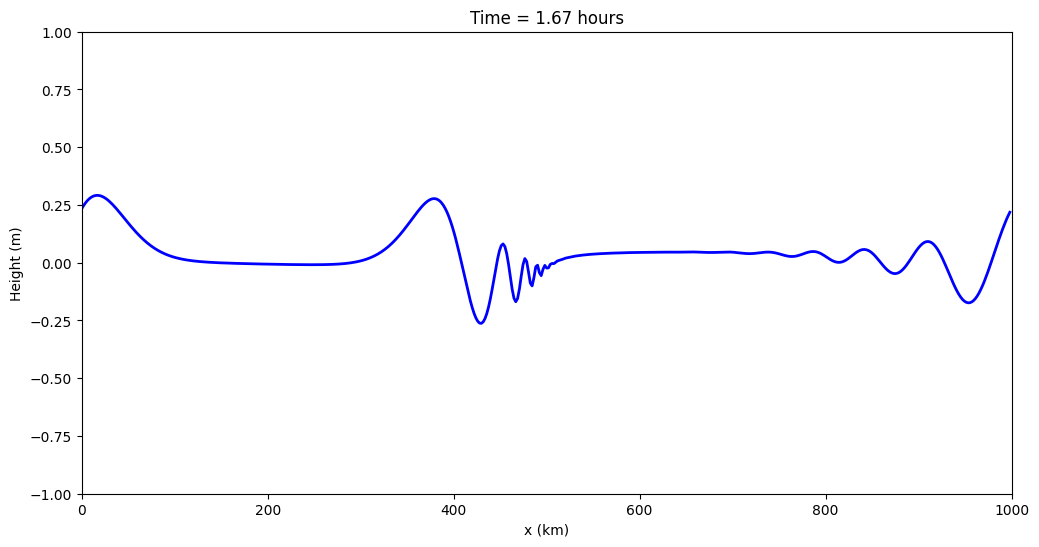

In [4]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Specify the axis limits and labels
plt.xlim((0, Lx / (1*kilometer)))
plt.ylim((-1, 1))
plt.xlabel('x (km)')
plt.ylabel('Height (m)')

# Create objects that will change during the animation
txt_title = plt.title('')
height, = plt.plot([], [], 'b', lw=2)

# Define an animation function
def drawframe(n):
    height.set_data(x/(1*kilometer), h_save[n,:])
    txt_title.set_text('Time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())


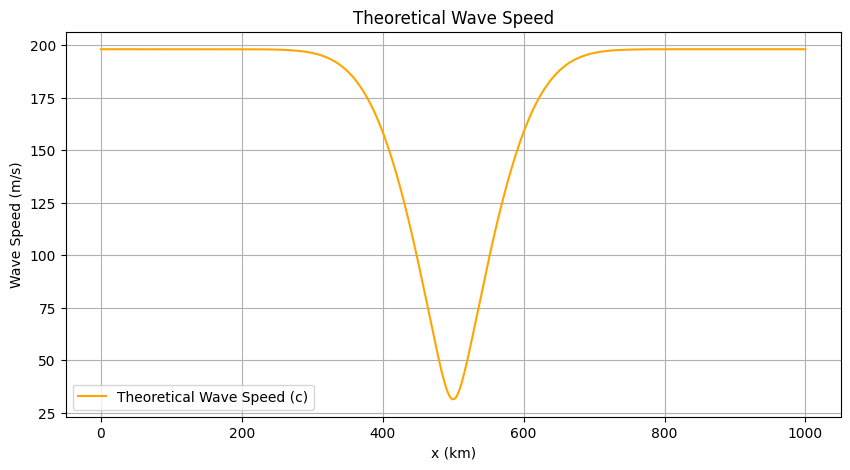

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
g = 9.81  # Gravitational acceleration (m/s^2)
H0 = 4000  # Reference ocean depth (m)
H_min = 100  # Minimum depth above the seamount (m)
x2 = 500 * 1e3  # Center of the seamount (m)
w2 = 100 * 1e3  # Width of the seamount (m)
Lx = 1000 * 1e3  # Domain length (m)
Nx = 512  # Number of grid points in x

# Generate spatial grid
x = np.linspace(0, Lx, Nx)

# Compute the bathymetry H(x)
H = H0 - (H0 - H_min) * np.exp(-(x - x2)**2 / w2**2)

# Compute the theoretical wave speed
c_theoretical = np.sqrt(g * H)

# Plot the theoretical wave speed
plt.figure(figsize=(10, 5))
plt.plot(x / 1e3, c_theoretical, label="Theoretical Wave Speed (c)", color="orange")
plt.xlabel("x (km)")
plt.ylabel("Wave Speed (m/s)")
plt.title("Theoretical Wave Speed")
plt.grid()
plt.legend()
plt.show()


### 1.3 Student investigation
<a id='section1pt3'></a>
In the cells below, provide an expression for the expected wave speed and state any assumptions that are necessary to arrive at this. Then plot the wave speed from the output above and compare this with the expected value.

ADD EXPRESSION FOR EXPECTED WAVE SPEED AND EXPLANATION HERE

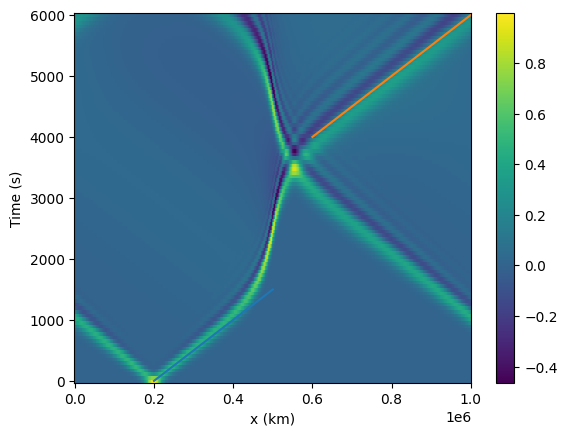

[4000.         4040.81632653 4081.63265306 4122.44897959 4163.26530612
 4204.08163265 4244.89795918 4285.71428571 4326.53061224 4367.34693878
 4408.16326531 4448.97959184 4489.79591837 4530.6122449  4571.42857143
 4612.24489796 4653.06122449 4693.87755102 4734.69387755 4775.51020408
 4816.32653061 4857.14285714 4897.95918367 4938.7755102  4979.59183673
 5020.40816327 5061.2244898  5102.04081633 5142.85714286 5183.67346939
 5224.48979592 5265.30612245 5306.12244898 5346.93877551 5387.75510204
 5428.57142857 5469.3877551  5510.20408163 5551.02040816 5591.83673469
 5632.65306122 5673.46938776 5714.28571429 5755.10204082 5795.91836735
 5836.73469388 5877.55102041 5918.36734694 5959.18367347 6000.        ]


In [17]:
plt.pcolor(x, t_save, h_save)

plt.plot(np.linspace(2e5,5e5), np.linspace(0,3e5)/200)
plt.plot(np.linspace(6e5,1e6), np.linspace(8e5,1.2e6)/200)
#plt.plot(x-2e5, x/200)
plt.xlabel('x (km)')
plt.ylabel('Time (s)')
plt.colorbar()
plt.show()

COMMENT ON RESULTS

- Slow down when encountering seamount, speed up afterwards

## 2.  2D Shallow water equations

Now, let's see how things change if we move to two dimensions. The script below solves the 2D shallow water equations:

$$ \partial_t u + g \partial_x(h) = - u*\partial_x u - v*\partial_y u$$
$$ \partial_t u + g \partial_y(h) = - u*\partial_x v - v*\partial_y v$$
$$ \partial_t h + H (\partial_x(u) + \partial_y(v)) = -\partial_x(h*u) - \partial_y(h*v)$$

We will solve these equations in a square domain with periodic boundary conditions. We will again initialize with a Gaussian height disturbance and with no water motion, but this time in 2D:

$$ h=e^{-(x^2+y^2)/w^2} $$
$$ u=0 $$
$$ v=0 $$

### 2.1  Dedalus script to solve the 2D shallow water equations

In [31]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size in x
Ly = 1000 * kilometer # The domain size in y
Nx = 64 # The number of gridpoints in x
Ny = 64 # The number of gridpoints in y
g = 9.81 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Reference ocean depth
width = 100 * kilometer # Set the width of the initial Gaussian

timestep = 60 * second # Specify the timestep
stop_sim_time = 30 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(-Lx/2, Lx/2), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2), dealias=3/2)

x, y = dist.local_grids(xbasis, ybasis)

# Fields
u = dist.Field(name='u', bases=(xbasis, ybasis))
v = dist.Field(name='v', bases=(xbasis, ybasis))
h = dist.Field(name='h', bases=(xbasis, ybasis))

# Initial conditions
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
v.change_scales(1)
h['g'] = np.exp(-(x**2+y**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
u['g'] = 0
v['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, coords['x'])
dy = lambda a: dedalus.Differentiate(a, coords['y'])

# Problem
problem = dedalus.IVP([u, v, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u) - v*dy(u)")
problem.add_equation("dt(v) + g*dy(h) = - u*dx(v) - v*dy(v)")
problem.add_equation("dt(h) + H*(dx(u) + dy(v)) = - dx(h*u) - dy(h*v)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')
snapshots.add_task(v, name='v')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing

INFO:subsystems:Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 1s, Rate: 6.2e+01/s


2024-11-21 19:20:56,963 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 1s, Rate: 6.2e+01/s


INFO:subsystems:Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 7.0e+01/s


2024-11-21 19:20:57,004 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 7.0e+01/s


INFO:subsystems:Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 7.2e+01/s


2024-11-21 19:20:57,058 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 7.2e+01/s


INFO:subsystems:Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 7.4e+01/s


2024-11-21 19:20:57,110 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 7.4e+01/s


INFO:subsystems:Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 6.8e+01/s


2024-11-21 19:20:57,184 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 6.8e+01/s


INFO:subsystems:Building subproblem matrices 20/32 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 6.3e+01/s


2024-11-21 19:20:57,263 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 6.3e+01/s


INFO:subsystems:Building subproblem matrices 24/32 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 6.3e+01/s


2024-11-21 19:20:57,329 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 6.3e+01/s


INFO:subsystems:Building subproblem matrices 28/32 (~88%) Elapsed: 0s, Remaining: 0s, Rate: 6.5e+01/s


2024-11-21 19:20:57,379 subsystems 0/1 INFO :: Building subproblem matrices 28/32 (~88%) Elapsed: 0s, Remaining: 0s, Rate: 6.5e+01/s


INFO:subsystems:Building subproblem matrices 32/32 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.5e+01/s


2024-11-21 19:20:57,436 subsystems 0/1 INFO :: Building subproblem matrices 32/32 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.5e+01/s


INFO:__main__:Starting main loop


2024-11-21 19:20:57,446 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2024-11-21 19:20:57,939 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 30


2024-11-21 19:20:57,943 solvers 0/1 INFO :: Final iteration: 30


INFO:solvers:Final sim time: 1800.0


2024-11-21 19:20:57,947 solvers 0/1 INFO :: Final sim time: 1800.0


INFO:solvers:Setup time (init - iter 0): 0.5433 sec


2024-11-21 19:20:57,950 solvers 0/1 INFO :: Setup time (init - iter 0): 0.5433 sec


INFO:solvers:Warmup time (iter 0-10): 0.2227 sec


2024-11-21 19:20:57,953 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.2227 sec


INFO:solvers:Run time (iter 10-end): 0.2636 sec


2024-11-21 19:20:57,955 solvers 0/1 INFO :: Run time (iter 10-end): 0.2636 sec


INFO:solvers:CPU time (iter 10-end): 7.321e-05 cpu-hr


2024-11-21 19:20:57,957 solvers 0/1 INFO :: CPU time (iter 10-end): 7.321e-05 cpu-hr


INFO:solvers:Speed: 1.807e+06 mode-stages/cpu-sec


2024-11-21 19:20:57,959 solvers 0/1 INFO :: Speed: 1.807e+06 mode-stages/cpu-sec


### 2.2  Plotting
The code below will make a movie of the height as a function of x and y

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-11-21 19:12:04,431 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpl8xadj03/temp.m4v


2024-11-21 19:12:04,436 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpl8xadj03/temp.m4v


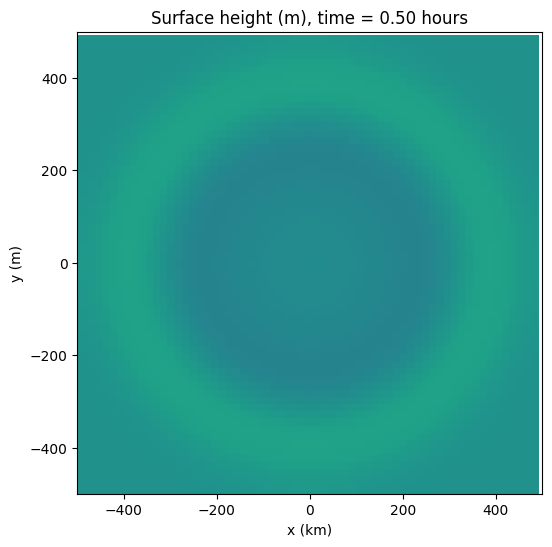

In [19]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the x and y coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf # clear the figure before plotting the next frame
    height = plt.pcolor(X/(1*kilometer), Y/(1*kilometer), h_save[n,:,:], vmin=-1, vmax=1)
    # Specify the axis limits and labels
    plt.xlim((-Lx/2 / (1*kilometer),Lx/2 / (1*kilometer)))
    plt.ylim((-Ly/2 / (1*kilometer),Ly/2 / (1*kilometer)))
    plt.xlabel('x (km)')
    plt.ylabel('y (m)')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### 2.3 Student investigation
<a id='section2pt3'></a>
Notice how the amplitude of the Tsunami wave decreases with distance from the source location. In the cell below, make a prediction for how the wave amplitude will vary as a function of distance from the origin (x=0, y=0) using conservation of energy. Then, make a plot or plots comparing your prediction for the wave amplitude compared with the results from the simulation.

Try out several different possible initial conditions for the surface height, $h$. How does the shape of the resulting waves change?

ADD PREDICTION OF WAVE AMPLITUDE HERE (a few sentences and/or equations)

- Let a = amplitude
- Assume wave intensity, I, is proportional to a^2
- I is also defined to be energy/area
- At the start there is no kinetic energy, only potential energy. a = a0. I is proportional to a0^2
- The area of the ring spreading out, A, is proportional to 2πr, where r = \sqrt(x^2+y^2)
- Energy = I x A is proportional to a0^2
- Since I is proportional to a^2
- a^2 is proportional to a0^2/r
- Taking the square root:
- a is proportional to a0/\sqrt{r}

In [20]:
# ADD CODE TO MAKE PLOTS HERE

# Take consistent y value, along the line, how does the amplitude change
# in h_save, index for y=0 line, see how the h changes
# should start high, decay as move away from centre
# Prediction should scale like h/sqrt r
# plot prediction - not going to 'fit' - just proportional to. Assign a value for initial amplitude



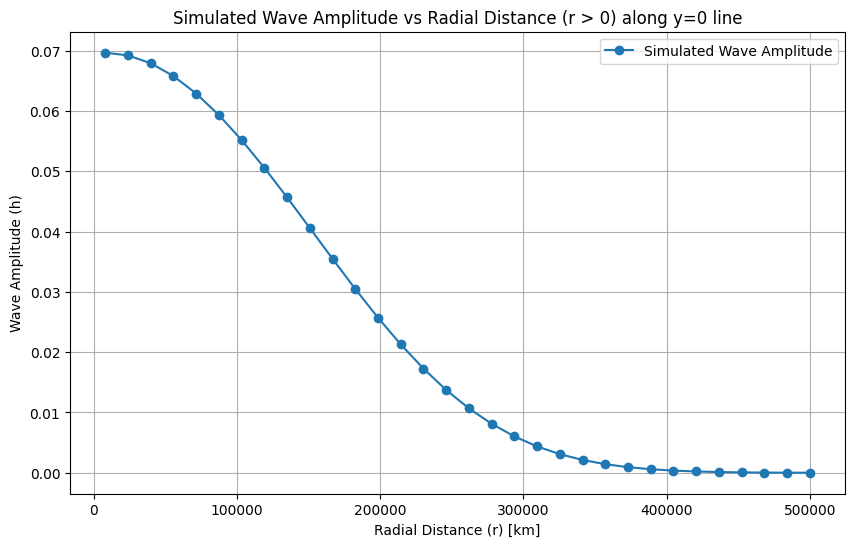

In [40]:
# Extract h along y=0 for the first time step
h_line = h_save[:, 0, :]  # Amplitude along x for the first time step

# Radial distance along x-axis
r = np.linspace(-Lx/2, Lx/2, Nx)  # Create the x-coordinate grid for the domain

# Filter for r > 0
r_positive = r[r > 0]  # Keep only positive values of r
h_positive = h_line[:, r > 0]  # Corresponding h values for r > 0

# Plot only the simulated wave amplitude for r > 0
plt.figure(figsize=(10, 6))
plt.plot(r_positive, np.max(h_positive, axis=0), label="Simulated Wave Amplitude", marker="o")
plt.xlabel("Radial Distance (r) [km]")
plt.ylabel("Wave Amplitude (h)")
plt.title("Simulated Wave Amplitude vs Radial Distance (r > 0) along y=0 line")
plt.legend()
plt.grid(True)
plt.show()


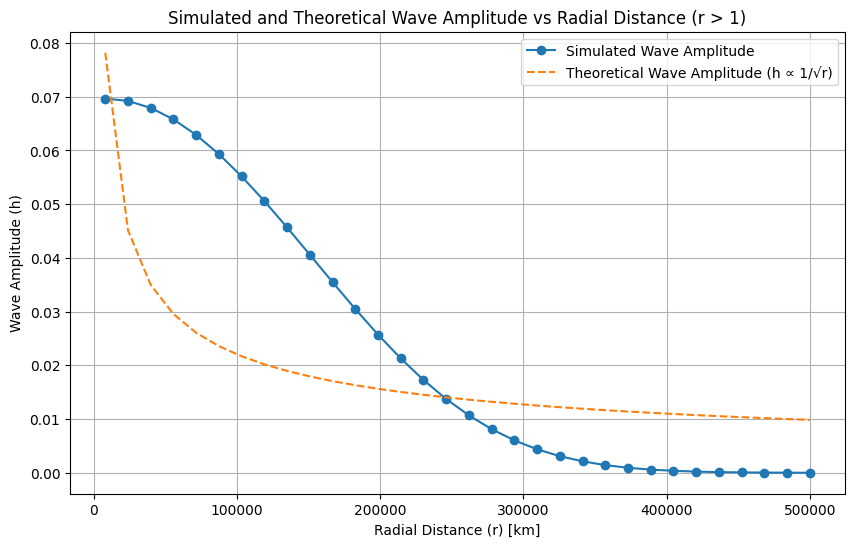

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
h0 = np.max(h_save[:, 0, :])  # Set h0 to match the max amplitude of the simulated data

# Extract h along y=0 for the first time step
h_line = h_save[:, 0, :]  # Amplitude along x for the first time step

# Radial distance along x-axis
r = np.linspace(-Lx / 2, Lx / 2, Nx)  # Create the x-coordinate grid for the domain

# Filter for r > 1 to avoid division by zero
r_positive = r[r > 1]  # Keep only values of r > 1
h_positive = h_line[:, r > 1]  # Corresponding h values for r > 1

# Scaling factor to align the theoretical model with simulation
scaling_factor = 100  # Adjust based on comparison

# Theoretical wave amplitude based on scaling analysis
h_theoretical = scaling_factor * h0 / np.sqrt(r_positive)

# Plot simulated wave amplitude
plt.figure(figsize=(10, 6))
plt.plot(r_positive, np.max(h_positive, axis=0), label="Simulated Wave Amplitude", marker="o")

# Plot theoretical wave amplitude
plt.plot(r_positive, h_theoretical, label="Theoretical Wave Amplitude (h ∝ 1/√r)", linestyle="--")

# Add labels, legend, and grid
plt.xlabel("Radial Distance (r) [km]")
plt.ylabel("Wave Amplitude (h)")
plt.title("Simulated and Theoretical Wave Amplitude vs Radial Distance (r > 1)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


ADD DISCUSSION HERE (~1 paragraph)

- The simulation captures a more realistic, complex wave behavior compared to the simplistic theoretical model.
- Nonlinear terms (advection and mass flux) are included in the simulation, but the theoretical analysis assumes linear wave dynamics. The wave amplitude should decrease faster in the simulation than in the theoretical profile.

## 3. Shallow water equations on a sphere

Of course the Earth isn't a flat plane. A great strength of Dedalus is its flexibility to solve equations in various geometries. The script below solves the 2D shallow water equations on a spherical shell, where the azimuth and colatitude are the independent variables. The colatitude is the complementary angle to the latitude such that the colatitude is $0^\circ$ at the North Pole, $90^\circ$ at the Equator, and $180^\circ$ at the South Pole. The spherical geometry also allows us to take into account the Earth's rotation in a realistic way.

Specifically, we will solve the following equations:
$$ \partial_t \mathbf{u} + g \nabla h + 2 \Omega \hat{\mathbf{z}} \times \mathbf{u} = -\mathbf{u} \cdot \nabla \mathbf{u} $$
$$ \partial_t + H \nabla \cdot \mathbf{u} = -\nabla \cdot (h \mathbf{u}) $$

where $\mathbf{u}$ is the velocity vector, $\Omega$ is the Earth's angular velocity (in radians per second), and $\hat{\mathbf{z}}$ is a unit vector aligned with the North Pole. Note that we have written the equations above in vector form. Dedalus includes vector calculus operators that make it very natural to solve equations like this without worrying about the particular form of the vector operators in a curvilinear coordinate system.

### 3.1  Dedalus script for 2D shallow water equations on a sphere

In [41]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Parameters
Nphi = 128 # Number of gridpoints in phi (longitude)
Ntheta = 64 # Number of gridpoints in theta (colatitude)
R = 6.37122e3 * kilometer
Omega = 2 * np.pi / (1 * day) # Earth's angular velocity in radians per second
g = 9.80616 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Depth of the ocean
width = 2*np.pi*10/360 # Width of the initial Gaussian in radians
phi0 = np.pi # Longitude of the initial Gaussian height perturbation in radians
theta0 = np.pi/4 # Colatitude of the initial Gaussian height perturbation in radians

timestep = 600 * second
stop_sim_time = 10 * day

# Bases
coords = dedalus.S2Coordinates('phi', 'theta')
dist = dedalus.Distributor(coords, dtype=np.float64)
basis = dedalus.SphereBasis(coords, (Nphi, Ntheta), radius=R, dealias=3/2, dtype=np.float64)

# Define the coordinates
phi, theta = dist.local_grids(basis) # Longitude and colatitude
lat = 360*(np.pi / 2 - theta)/(2*np.pi)  # latitude in degrees

# Fields
u = dist.VectorField(coords, name='u', bases=basis)
h = dist.Field(name='h', bases=basis)

# Operators
# First, create an operator to perform the cross product: "z x ", where z is the local vertical unit vector
# The "skew" operator performs a 90 degree rotation of a vector field,
# so that skew([u,v]) = [-v, u].  MulCosine multiplies by the cosine of the latitude
zcross = lambda A: dedalus.MulCosine(dedalus.skew(A))

# Set the initial conditions
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
h['g'] = np.exp(-((phi-phi0)**2+(theta-theta0)**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
# Set the initial velocity to zero
u['g'][0] = 0 # the x-component of the velocity
u['g'][1] = 0 # the y-component of the velocity

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*grad(h) + 2*Omega*zcross(u) = - u@grad(u)")
problem.add_equation("dt(h) + H*div(u) = - div(h*u)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save = np.array(h_save)

INFO:subsystems:Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 2s, Rate: 2.7e+01/s


2024-11-21 19:34:07,371 subsystems 0/1 INFO :: Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 2s, Rate: 2.7e+01/s


INFO:subsystems:Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 2s, Rate: 3.4e+01/s


2024-11-21 19:34:07,538 subsystems 0/1 INFO :: Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 2s, Rate: 3.4e+01/s


INFO:subsystems:Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 3.5e+01/s


2024-11-21 19:34:07,732 subsystems 0/1 INFO :: Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 3.5e+01/s


INFO:subsystems:Building subproblem matrices 21/63 (~33%) Elapsed: 1s, Remaining: 1s, Rate: 3.6e+01/s


2024-11-21 19:34:07,917 subsystems 0/1 INFO :: Building subproblem matrices 21/63 (~33%) Elapsed: 1s, Remaining: 1s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 28/63 (~44%) Elapsed: 1s, Remaining: 1s, Rate: 3.7e+01/s


2024-11-21 19:34:08,094 subsystems 0/1 INFO :: Building subproblem matrices 28/63 (~44%) Elapsed: 1s, Remaining: 1s, Rate: 3.7e+01/s


INFO:subsystems:Building subproblem matrices 35/63 (~56%) Elapsed: 1s, Remaining: 1s, Rate: 3.6e+01/s


2024-11-21 19:34:08,298 subsystems 0/1 INFO :: Building subproblem matrices 35/63 (~56%) Elapsed: 1s, Remaining: 1s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 1s, Rate: 3.5e+01/s


2024-11-21 19:34:08,527 subsystems 0/1 INFO :: Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 1s, Rate: 3.5e+01/s


INFO:subsystems:Building subproblem matrices 49/63 (~78%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


2024-11-21 19:34:08,708 subsystems 0/1 INFO :: Building subproblem matrices 49/63 (~78%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 56/63 (~89%) Elapsed: 2s, Remaining: 0s, Rate: 3.6e+01/s


2024-11-21 19:34:08,895 subsystems 0/1 INFO :: Building subproblem matrices 56/63 (~89%) Elapsed: 2s, Remaining: 0s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 63/63 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 3.6e+01/s


2024-11-21 19:34:09,099 subsystems 0/1 INFO :: Building subproblem matrices 63/63 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 3.6e+01/s


INFO:__main__:Starting main loop


2024-11-21 19:34:09,109 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=6.000000e+02, dt=6.000000e+02


2024-11-21 19:34:13,239 __main__ 0/1 INFO :: Iteration=1, Time=6.000000e+02, dt=6.000000e+02


INFO:__main__:Iteration=11, Time=6.600000e+03, dt=6.000000e+02


2024-11-21 19:34:14,107 __main__ 0/1 INFO :: Iteration=11, Time=6.600000e+03, dt=6.000000e+02


INFO:__main__:Iteration=21, Time=1.260000e+04, dt=6.000000e+02


2024-11-21 19:34:14,595 __main__ 0/1 INFO :: Iteration=21, Time=1.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=31, Time=1.860000e+04, dt=6.000000e+02


2024-11-21 19:34:15,083 __main__ 0/1 INFO :: Iteration=31, Time=1.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=41, Time=2.460000e+04, dt=6.000000e+02


2024-11-21 19:34:15,584 __main__ 0/1 INFO :: Iteration=41, Time=2.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=51, Time=3.060000e+04, dt=6.000000e+02


2024-11-21 19:34:16,265 __main__ 0/1 INFO :: Iteration=51, Time=3.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=61, Time=3.660000e+04, dt=6.000000e+02


2024-11-21 19:34:16,979 __main__ 0/1 INFO :: Iteration=61, Time=3.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=71, Time=4.260000e+04, dt=6.000000e+02


2024-11-21 19:34:17,702 __main__ 0/1 INFO :: Iteration=71, Time=4.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=81, Time=4.860000e+04, dt=6.000000e+02


2024-11-21 19:34:18,465 __main__ 0/1 INFO :: Iteration=81, Time=4.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=91, Time=5.460000e+04, dt=6.000000e+02


2024-11-21 19:34:19,106 __main__ 0/1 INFO :: Iteration=91, Time=5.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=101, Time=6.060000e+04, dt=6.000000e+02


2024-11-21 19:34:19,583 __main__ 0/1 INFO :: Iteration=101, Time=6.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=111, Time=6.660000e+04, dt=6.000000e+02


2024-11-21 19:34:20,070 __main__ 0/1 INFO :: Iteration=111, Time=6.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=121, Time=7.260000e+04, dt=6.000000e+02


2024-11-21 19:34:20,546 __main__ 0/1 INFO :: Iteration=121, Time=7.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=131, Time=7.860000e+04, dt=6.000000e+02


2024-11-21 19:34:21,050 __main__ 0/1 INFO :: Iteration=131, Time=7.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=141, Time=8.460000e+04, dt=6.000000e+02


2024-11-21 19:34:21,529 __main__ 0/1 INFO :: Iteration=141, Time=8.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=151, Time=9.060000e+04, dt=6.000000e+02


2024-11-21 19:34:22,047 __main__ 0/1 INFO :: Iteration=151, Time=9.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=161, Time=9.660000e+04, dt=6.000000e+02


2024-11-21 19:34:22,551 __main__ 0/1 INFO :: Iteration=161, Time=9.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=171, Time=1.026000e+05, dt=6.000000e+02


2024-11-21 19:34:23,047 __main__ 0/1 INFO :: Iteration=171, Time=1.026000e+05, dt=6.000000e+02


INFO:__main__:Iteration=181, Time=1.086000e+05, dt=6.000000e+02


2024-11-21 19:34:23,552 __main__ 0/1 INFO :: Iteration=181, Time=1.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=191, Time=1.146000e+05, dt=6.000000e+02


2024-11-21 19:34:24,048 __main__ 0/1 INFO :: Iteration=191, Time=1.146000e+05, dt=6.000000e+02


INFO:__main__:Iteration=201, Time=1.206000e+05, dt=6.000000e+02


2024-11-21 19:34:24,612 __main__ 0/1 INFO :: Iteration=201, Time=1.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=211, Time=1.266000e+05, dt=6.000000e+02


2024-11-21 19:34:25,104 __main__ 0/1 INFO :: Iteration=211, Time=1.266000e+05, dt=6.000000e+02


INFO:__main__:Iteration=221, Time=1.326000e+05, dt=6.000000e+02


2024-11-21 19:34:25,638 __main__ 0/1 INFO :: Iteration=221, Time=1.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=231, Time=1.386000e+05, dt=6.000000e+02


2024-11-21 19:34:26,131 __main__ 0/1 INFO :: Iteration=231, Time=1.386000e+05, dt=6.000000e+02


INFO:__main__:Iteration=241, Time=1.446000e+05, dt=6.000000e+02


2024-11-21 19:34:26,607 __main__ 0/1 INFO :: Iteration=241, Time=1.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=251, Time=1.506000e+05, dt=6.000000e+02


2024-11-21 19:34:27,118 __main__ 0/1 INFO :: Iteration=251, Time=1.506000e+05, dt=6.000000e+02


INFO:__main__:Iteration=261, Time=1.566000e+05, dt=6.000000e+02


2024-11-21 19:34:27,611 __main__ 0/1 INFO :: Iteration=261, Time=1.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=271, Time=1.626000e+05, dt=6.000000e+02


2024-11-21 19:34:28,149 __main__ 0/1 INFO :: Iteration=271, Time=1.626000e+05, dt=6.000000e+02


INFO:__main__:Iteration=281, Time=1.686000e+05, dt=6.000000e+02


2024-11-21 19:34:28,663 __main__ 0/1 INFO :: Iteration=281, Time=1.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=291, Time=1.746000e+05, dt=6.000000e+02


2024-11-21 19:34:29,299 __main__ 0/1 INFO :: Iteration=291, Time=1.746000e+05, dt=6.000000e+02


INFO:__main__:Iteration=301, Time=1.806000e+05, dt=6.000000e+02


2024-11-21 19:34:30,048 __main__ 0/1 INFO :: Iteration=301, Time=1.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=311, Time=1.866000e+05, dt=6.000000e+02


2024-11-21 19:34:30,794 __main__ 0/1 INFO :: Iteration=311, Time=1.866000e+05, dt=6.000000e+02


INFO:__main__:Iteration=321, Time=1.926000e+05, dt=6.000000e+02


2024-11-21 19:34:31,563 __main__ 0/1 INFO :: Iteration=321, Time=1.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=331, Time=1.986000e+05, dt=6.000000e+02


2024-11-21 19:34:32,236 __main__ 0/1 INFO :: Iteration=331, Time=1.986000e+05, dt=6.000000e+02


INFO:__main__:Iteration=341, Time=2.046000e+05, dt=6.000000e+02


2024-11-21 19:34:32,725 __main__ 0/1 INFO :: Iteration=341, Time=2.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=351, Time=2.106000e+05, dt=6.000000e+02


2024-11-21 19:34:33,207 __main__ 0/1 INFO :: Iteration=351, Time=2.106000e+05, dt=6.000000e+02


INFO:__main__:Iteration=361, Time=2.166000e+05, dt=6.000000e+02


2024-11-21 19:34:33,772 __main__ 0/1 INFO :: Iteration=361, Time=2.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=371, Time=2.226000e+05, dt=6.000000e+02


2024-11-21 19:34:34,255 __main__ 0/1 INFO :: Iteration=371, Time=2.226000e+05, dt=6.000000e+02


INFO:__main__:Iteration=381, Time=2.286000e+05, dt=6.000000e+02


2024-11-21 19:34:34,748 __main__ 0/1 INFO :: Iteration=381, Time=2.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=391, Time=2.346000e+05, dt=6.000000e+02


2024-11-21 19:34:35,229 __main__ 0/1 INFO :: Iteration=391, Time=2.346000e+05, dt=6.000000e+02


INFO:__main__:Iteration=401, Time=2.406000e+05, dt=6.000000e+02


2024-11-21 19:34:35,739 __main__ 0/1 INFO :: Iteration=401, Time=2.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=411, Time=2.466000e+05, dt=6.000000e+02


2024-11-21 19:34:36,220 __main__ 0/1 INFO :: Iteration=411, Time=2.466000e+05, dt=6.000000e+02


INFO:__main__:Iteration=421, Time=2.526000e+05, dt=6.000000e+02


2024-11-21 19:34:36,715 __main__ 0/1 INFO :: Iteration=421, Time=2.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=431, Time=2.586000e+05, dt=6.000000e+02


2024-11-21 19:34:37,234 __main__ 0/1 INFO :: Iteration=431, Time=2.586000e+05, dt=6.000000e+02


INFO:__main__:Iteration=441, Time=2.646000e+05, dt=6.000000e+02


2024-11-21 19:34:37,772 __main__ 0/1 INFO :: Iteration=441, Time=2.646000e+05, dt=6.000000e+02


INFO:__main__:Iteration=451, Time=2.706000e+05, dt=6.000000e+02


2024-11-21 19:34:38,255 __main__ 0/1 INFO :: Iteration=451, Time=2.706000e+05, dt=6.000000e+02


INFO:__main__:Iteration=461, Time=2.766000e+05, dt=6.000000e+02


2024-11-21 19:34:38,761 __main__ 0/1 INFO :: Iteration=461, Time=2.766000e+05, dt=6.000000e+02


INFO:__main__:Iteration=471, Time=2.826000e+05, dt=6.000000e+02


2024-11-21 19:34:39,284 __main__ 0/1 INFO :: Iteration=471, Time=2.826000e+05, dt=6.000000e+02


INFO:__main__:Iteration=481, Time=2.886000e+05, dt=6.000000e+02


2024-11-21 19:34:39,801 __main__ 0/1 INFO :: Iteration=481, Time=2.886000e+05, dt=6.000000e+02


INFO:__main__:Iteration=491, Time=2.946000e+05, dt=6.000000e+02


2024-11-21 19:34:40,287 __main__ 0/1 INFO :: Iteration=491, Time=2.946000e+05, dt=6.000000e+02


INFO:__main__:Iteration=501, Time=3.006000e+05, dt=6.000000e+02


2024-11-21 19:34:40,794 __main__ 0/1 INFO :: Iteration=501, Time=3.006000e+05, dt=6.000000e+02


INFO:__main__:Iteration=511, Time=3.066000e+05, dt=6.000000e+02


2024-11-21 19:34:41,299 __main__ 0/1 INFO :: Iteration=511, Time=3.066000e+05, dt=6.000000e+02


INFO:__main__:Iteration=521, Time=3.126000e+05, dt=6.000000e+02


2024-11-21 19:34:41,795 __main__ 0/1 INFO :: Iteration=521, Time=3.126000e+05, dt=6.000000e+02


INFO:__main__:Iteration=531, Time=3.186000e+05, dt=6.000000e+02


2024-11-21 19:34:42,412 __main__ 0/1 INFO :: Iteration=531, Time=3.186000e+05, dt=6.000000e+02


INFO:__main__:Iteration=541, Time=3.246000e+05, dt=6.000000e+02


2024-11-21 19:34:43,132 __main__ 0/1 INFO :: Iteration=541, Time=3.246000e+05, dt=6.000000e+02


INFO:__main__:Iteration=551, Time=3.306000e+05, dt=6.000000e+02


2024-11-21 19:34:43,863 __main__ 0/1 INFO :: Iteration=551, Time=3.306000e+05, dt=6.000000e+02


INFO:__main__:Iteration=561, Time=3.366000e+05, dt=6.000000e+02


2024-11-21 19:34:44,621 __main__ 0/1 INFO :: Iteration=561, Time=3.366000e+05, dt=6.000000e+02


INFO:__main__:Iteration=571, Time=3.426000e+05, dt=6.000000e+02


2024-11-21 19:34:45,408 __main__ 0/1 INFO :: Iteration=571, Time=3.426000e+05, dt=6.000000e+02


INFO:__main__:Iteration=581, Time=3.486000e+05, dt=6.000000e+02


2024-11-21 19:34:45,921 __main__ 0/1 INFO :: Iteration=581, Time=3.486000e+05, dt=6.000000e+02


INFO:__main__:Iteration=591, Time=3.546000e+05, dt=6.000000e+02


2024-11-21 19:34:46,425 __main__ 0/1 INFO :: Iteration=591, Time=3.546000e+05, dt=6.000000e+02


INFO:__main__:Iteration=601, Time=3.606000e+05, dt=6.000000e+02


2024-11-21 19:34:46,935 __main__ 0/1 INFO :: Iteration=601, Time=3.606000e+05, dt=6.000000e+02


INFO:__main__:Iteration=611, Time=3.666000e+05, dt=6.000000e+02


2024-11-21 19:34:47,453 __main__ 0/1 INFO :: Iteration=611, Time=3.666000e+05, dt=6.000000e+02


INFO:__main__:Iteration=621, Time=3.726000e+05, dt=6.000000e+02


2024-11-21 19:34:48,176 __main__ 0/1 INFO :: Iteration=621, Time=3.726000e+05, dt=6.000000e+02


INFO:__main__:Iteration=631, Time=3.786000e+05, dt=6.000000e+02


2024-11-21 19:34:48,710 __main__ 0/1 INFO :: Iteration=631, Time=3.786000e+05, dt=6.000000e+02


INFO:__main__:Iteration=641, Time=3.846000e+05, dt=6.000000e+02


2024-11-21 19:34:49,201 __main__ 0/1 INFO :: Iteration=641, Time=3.846000e+05, dt=6.000000e+02


INFO:__main__:Iteration=651, Time=3.906000e+05, dt=6.000000e+02


2024-11-21 19:34:49,733 __main__ 0/1 INFO :: Iteration=651, Time=3.906000e+05, dt=6.000000e+02


INFO:__main__:Iteration=661, Time=3.966000e+05, dt=6.000000e+02


2024-11-21 19:34:50,233 __main__ 0/1 INFO :: Iteration=661, Time=3.966000e+05, dt=6.000000e+02


INFO:__main__:Iteration=671, Time=4.026000e+05, dt=6.000000e+02


2024-11-21 19:34:50,780 __main__ 0/1 INFO :: Iteration=671, Time=4.026000e+05, dt=6.000000e+02


INFO:__main__:Iteration=681, Time=4.086000e+05, dt=6.000000e+02


2024-11-21 19:34:51,288 __main__ 0/1 INFO :: Iteration=681, Time=4.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=691, Time=4.146000e+05, dt=6.000000e+02


2024-11-21 19:34:51,769 __main__ 0/1 INFO :: Iteration=691, Time=4.146000e+05, dt=6.000000e+02


INFO:__main__:Iteration=701, Time=4.206000e+05, dt=6.000000e+02


2024-11-21 19:34:52,296 __main__ 0/1 INFO :: Iteration=701, Time=4.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=711, Time=4.266000e+05, dt=6.000000e+02


2024-11-21 19:34:52,772 __main__ 0/1 INFO :: Iteration=711, Time=4.266000e+05, dt=6.000000e+02


INFO:__main__:Iteration=721, Time=4.326000e+05, dt=6.000000e+02


2024-11-21 19:34:53,261 __main__ 0/1 INFO :: Iteration=721, Time=4.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=731, Time=4.386000e+05, dt=6.000000e+02


2024-11-21 19:34:53,735 __main__ 0/1 INFO :: Iteration=731, Time=4.386000e+05, dt=6.000000e+02


INFO:__main__:Iteration=741, Time=4.446000e+05, dt=6.000000e+02


2024-11-21 19:34:54,223 __main__ 0/1 INFO :: Iteration=741, Time=4.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=751, Time=4.506000e+05, dt=6.000000e+02


2024-11-21 19:34:54,707 __main__ 0/1 INFO :: Iteration=751, Time=4.506000e+05, dt=6.000000e+02


INFO:__main__:Iteration=761, Time=4.566000e+05, dt=6.000000e+02


2024-11-21 19:34:55,194 __main__ 0/1 INFO :: Iteration=761, Time=4.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=771, Time=4.626000e+05, dt=6.000000e+02


2024-11-21 19:34:55,829 __main__ 0/1 INFO :: Iteration=771, Time=4.626000e+05, dt=6.000000e+02


INFO:__main__:Iteration=781, Time=4.686000e+05, dt=6.000000e+02


2024-11-21 19:34:56,553 __main__ 0/1 INFO :: Iteration=781, Time=4.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=791, Time=4.746000e+05, dt=6.000000e+02


2024-11-21 19:34:57,274 __main__ 0/1 INFO :: Iteration=791, Time=4.746000e+05, dt=6.000000e+02


INFO:__main__:Iteration=801, Time=4.806000e+05, dt=6.000000e+02


2024-11-21 19:34:58,044 __main__ 0/1 INFO :: Iteration=801, Time=4.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=811, Time=4.866000e+05, dt=6.000000e+02


2024-11-21 19:34:58,783 __main__ 0/1 INFO :: Iteration=811, Time=4.866000e+05, dt=6.000000e+02


INFO:__main__:Iteration=821, Time=4.926000e+05, dt=6.000000e+02


2024-11-21 19:34:59,256 __main__ 0/1 INFO :: Iteration=821, Time=4.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=831, Time=4.986000e+05, dt=6.000000e+02


2024-11-21 19:34:59,738 __main__ 0/1 INFO :: Iteration=831, Time=4.986000e+05, dt=6.000000e+02


INFO:__main__:Iteration=841, Time=5.046000e+05, dt=6.000000e+02


2024-11-21 19:35:00,228 __main__ 0/1 INFO :: Iteration=841, Time=5.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=851, Time=5.106000e+05, dt=6.000000e+02


2024-11-21 19:35:00,707 __main__ 0/1 INFO :: Iteration=851, Time=5.106000e+05, dt=6.000000e+02


INFO:__main__:Iteration=861, Time=5.166000e+05, dt=6.000000e+02


2024-11-21 19:35:01,178 __main__ 0/1 INFO :: Iteration=861, Time=5.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=871, Time=5.226000e+05, dt=6.000000e+02


2024-11-21 19:35:01,669 __main__ 0/1 INFO :: Iteration=871, Time=5.226000e+05, dt=6.000000e+02


INFO:__main__:Iteration=881, Time=5.286000e+05, dt=6.000000e+02


2024-11-21 19:35:02,146 __main__ 0/1 INFO :: Iteration=881, Time=5.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=891, Time=5.346000e+05, dt=6.000000e+02


2024-11-21 19:35:02,654 __main__ 0/1 INFO :: Iteration=891, Time=5.346000e+05, dt=6.000000e+02


INFO:__main__:Iteration=901, Time=5.406000e+05, dt=6.000000e+02


2024-11-21 19:35:03,142 __main__ 0/1 INFO :: Iteration=901, Time=5.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=911, Time=5.466000e+05, dt=6.000000e+02


2024-11-21 19:35:03,632 __main__ 0/1 INFO :: Iteration=911, Time=5.466000e+05, dt=6.000000e+02


INFO:__main__:Iteration=921, Time=5.526000e+05, dt=6.000000e+02


2024-11-21 19:35:04,110 __main__ 0/1 INFO :: Iteration=921, Time=5.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=931, Time=5.586000e+05, dt=6.000000e+02


2024-11-21 19:35:04,596 __main__ 0/1 INFO :: Iteration=931, Time=5.586000e+05, dt=6.000000e+02


INFO:__main__:Iteration=941, Time=5.646000e+05, dt=6.000000e+02


2024-11-21 19:35:05,082 __main__ 0/1 INFO :: Iteration=941, Time=5.646000e+05, dt=6.000000e+02


INFO:__main__:Iteration=951, Time=5.706000e+05, dt=6.000000e+02


2024-11-21 19:35:05,576 __main__ 0/1 INFO :: Iteration=951, Time=5.706000e+05, dt=6.000000e+02


INFO:__main__:Iteration=961, Time=5.766000e+05, dt=6.000000e+02


2024-11-21 19:35:06,061 __main__ 0/1 INFO :: Iteration=961, Time=5.766000e+05, dt=6.000000e+02


INFO:__main__:Iteration=971, Time=5.826000e+05, dt=6.000000e+02


2024-11-21 19:35:06,562 __main__ 0/1 INFO :: Iteration=971, Time=5.826000e+05, dt=6.000000e+02


INFO:__main__:Iteration=981, Time=5.886000e+05, dt=6.000000e+02


2024-11-21 19:35:07,046 __main__ 0/1 INFO :: Iteration=981, Time=5.886000e+05, dt=6.000000e+02


INFO:__main__:Iteration=991, Time=5.946000e+05, dt=6.000000e+02


2024-11-21 19:35:07,549 __main__ 0/1 INFO :: Iteration=991, Time=5.946000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1001, Time=6.006000e+05, dt=6.000000e+02


2024-11-21 19:35:08,042 __main__ 0/1 INFO :: Iteration=1001, Time=6.006000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1011, Time=6.066000e+05, dt=6.000000e+02


2024-11-21 19:35:08,532 __main__ 0/1 INFO :: Iteration=1011, Time=6.066000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1021, Time=6.126000e+05, dt=6.000000e+02


2024-11-21 19:35:09,288 __main__ 0/1 INFO :: Iteration=1021, Time=6.126000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1031, Time=6.186000e+05, dt=6.000000e+02


2024-11-21 19:35:10,039 __main__ 0/1 INFO :: Iteration=1031, Time=6.186000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1041, Time=6.246000e+05, dt=6.000000e+02


2024-11-21 19:35:10,781 __main__ 0/1 INFO :: Iteration=1041, Time=6.246000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1051, Time=6.306000e+05, dt=6.000000e+02


2024-11-21 19:35:11,528 __main__ 0/1 INFO :: Iteration=1051, Time=6.306000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1061, Time=6.366000e+05, dt=6.000000e+02


2024-11-21 19:35:12,230 __main__ 0/1 INFO :: Iteration=1061, Time=6.366000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1071, Time=6.426000e+05, dt=6.000000e+02


2024-11-21 19:35:12,736 __main__ 0/1 INFO :: Iteration=1071, Time=6.426000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1081, Time=6.486000e+05, dt=6.000000e+02


2024-11-21 19:35:13,224 __main__ 0/1 INFO :: Iteration=1081, Time=6.486000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1091, Time=6.546000e+05, dt=6.000000e+02


2024-11-21 19:35:13,705 __main__ 0/1 INFO :: Iteration=1091, Time=6.546000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1101, Time=6.606000e+05, dt=6.000000e+02


2024-11-21 19:35:14,228 __main__ 0/1 INFO :: Iteration=1101, Time=6.606000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1111, Time=6.666000e+05, dt=6.000000e+02


2024-11-21 19:35:14,771 __main__ 0/1 INFO :: Iteration=1111, Time=6.666000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1121, Time=6.726000e+05, dt=6.000000e+02


2024-11-21 19:35:15,503 __main__ 0/1 INFO :: Iteration=1121, Time=6.726000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1131, Time=6.786000e+05, dt=6.000000e+02


2024-11-21 19:35:16,259 __main__ 0/1 INFO :: Iteration=1131, Time=6.786000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1141, Time=6.846000e+05, dt=6.000000e+02


2024-11-21 19:35:17,036 __main__ 0/1 INFO :: Iteration=1141, Time=6.846000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1151, Time=6.906000e+05, dt=6.000000e+02


2024-11-21 19:35:17,808 __main__ 0/1 INFO :: Iteration=1151, Time=6.906000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1161, Time=6.966000e+05, dt=6.000000e+02


2024-11-21 19:35:18,364 __main__ 0/1 INFO :: Iteration=1161, Time=6.966000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1171, Time=7.026000e+05, dt=6.000000e+02


2024-11-21 19:35:18,840 __main__ 0/1 INFO :: Iteration=1171, Time=7.026000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1181, Time=7.086000e+05, dt=6.000000e+02


2024-11-21 19:35:19,335 __main__ 0/1 INFO :: Iteration=1181, Time=7.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1191, Time=7.146000e+05, dt=6.000000e+02


2024-11-21 19:35:19,825 __main__ 0/1 INFO :: Iteration=1191, Time=7.146000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1201, Time=7.206000e+05, dt=6.000000e+02


2024-11-21 19:35:20,330 __main__ 0/1 INFO :: Iteration=1201, Time=7.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1211, Time=7.266000e+05, dt=6.000000e+02


2024-11-21 19:35:20,840 __main__ 0/1 INFO :: Iteration=1211, Time=7.266000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1221, Time=7.326000e+05, dt=6.000000e+02


2024-11-21 19:35:21,338 __main__ 0/1 INFO :: Iteration=1221, Time=7.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1231, Time=7.386000e+05, dt=6.000000e+02


2024-11-21 19:35:21,819 __main__ 0/1 INFO :: Iteration=1231, Time=7.386000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1241, Time=7.446000e+05, dt=6.000000e+02


2024-11-21 19:35:22,418 __main__ 0/1 INFO :: Iteration=1241, Time=7.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1251, Time=7.506000e+05, dt=6.000000e+02


2024-11-21 19:35:23,187 __main__ 0/1 INFO :: Iteration=1251, Time=7.506000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1261, Time=7.566000e+05, dt=6.000000e+02


2024-11-21 19:35:23,960 __main__ 0/1 INFO :: Iteration=1261, Time=7.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1271, Time=7.626000e+05, dt=6.000000e+02


2024-11-21 19:35:24,729 __main__ 0/1 INFO :: Iteration=1271, Time=7.626000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1281, Time=7.686000e+05, dt=6.000000e+02


2024-11-21 19:35:25,484 __main__ 0/1 INFO :: Iteration=1281, Time=7.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1291, Time=7.746000e+05, dt=6.000000e+02


2024-11-21 19:35:25,974 __main__ 0/1 INFO :: Iteration=1291, Time=7.746000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1301, Time=7.806000e+05, dt=6.000000e+02


2024-11-21 19:35:26,472 __main__ 0/1 INFO :: Iteration=1301, Time=7.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1311, Time=7.866000e+05, dt=6.000000e+02


2024-11-21 19:35:26,967 __main__ 0/1 INFO :: Iteration=1311, Time=7.866000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1321, Time=7.926000e+05, dt=6.000000e+02


2024-11-21 19:35:27,471 __main__ 0/1 INFO :: Iteration=1321, Time=7.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1331, Time=7.986000e+05, dt=6.000000e+02


2024-11-21 19:35:27,961 __main__ 0/1 INFO :: Iteration=1331, Time=7.986000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1341, Time=8.046000e+05, dt=6.000000e+02


2024-11-21 19:35:28,440 __main__ 0/1 INFO :: Iteration=1341, Time=8.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1351, Time=8.106000e+05, dt=6.000000e+02


2024-11-21 19:35:28,924 __main__ 0/1 INFO :: Iteration=1351, Time=8.106000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1361, Time=8.166000e+05, dt=6.000000e+02


2024-11-21 19:35:29,403 __main__ 0/1 INFO :: Iteration=1361, Time=8.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1371, Time=8.226000e+05, dt=6.000000e+02


2024-11-21 19:35:29,897 __main__ 0/1 INFO :: Iteration=1371, Time=8.226000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1381, Time=8.286000e+05, dt=6.000000e+02


2024-11-21 19:35:30,424 __main__ 0/1 INFO :: Iteration=1381, Time=8.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1391, Time=8.346000e+05, dt=6.000000e+02


2024-11-21 19:35:30,942 __main__ 0/1 INFO :: Iteration=1391, Time=8.346000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1401, Time=8.406000e+05, dt=6.000000e+02


2024-11-21 19:35:31,447 __main__ 0/1 INFO :: Iteration=1401, Time=8.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1411, Time=8.466000e+05, dt=6.000000e+02


2024-11-21 19:35:31,969 __main__ 0/1 INFO :: Iteration=1411, Time=8.466000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1421, Time=8.526000e+05, dt=6.000000e+02


2024-11-21 19:35:32,456 __main__ 0/1 INFO :: Iteration=1421, Time=8.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1431, Time=8.586000e+05, dt=6.000000e+02


2024-11-21 19:35:32,961 __main__ 0/1 INFO :: Iteration=1431, Time=8.586000e+05, dt=6.000000e+02


INFO:solvers:Simulation stop time reached.


2024-11-21 19:35:33,402 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 1440


2024-11-21 19:35:33,406 solvers 0/1 INFO :: Final iteration: 1440


INFO:solvers:Final sim time: 864000.0


2024-11-21 19:35:33,410 solvers 0/1 INFO :: Final sim time: 864000.0


INFO:solvers:Setup time (init - iter 0): 5.067 sec


2024-11-21 19:35:33,414 solvers 0/1 INFO :: Setup time (init - iter 0): 5.067 sec


INFO:solvers:Warmup time (iter 0-10): 1.705 sec


2024-11-21 19:35:33,419 solvers 0/1 INFO :: Warmup time (iter 0-10): 1.705 sec


INFO:solvers:Run time (iter 10-end): 79.34 sec


2024-11-21 19:35:33,423 solvers 0/1 INFO :: Run time (iter 10-end): 79.34 sec


INFO:solvers:CPU time (iter 10-end): 0.02204 cpu-hr


2024-11-21 19:35:33,428 solvers 0/1 INFO :: CPU time (iter 10-end): 0.02204 cpu-hr


INFO:solvers:Speed: 4.358e+05 mode-stages/cpu-sec


2024-11-21 19:35:33,432 solvers 0/1 INFO :: Speed: 4.358e+05 mode-stages/cpu-sec


### 3.2  Plotting
The code below will make a movie of the height as a function of x and y

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-11-21 19:37:17,139 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpcuiohnoj/temp.m4v


2024-11-21 19:37:17,144 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpcuiohnoj/temp.m4v


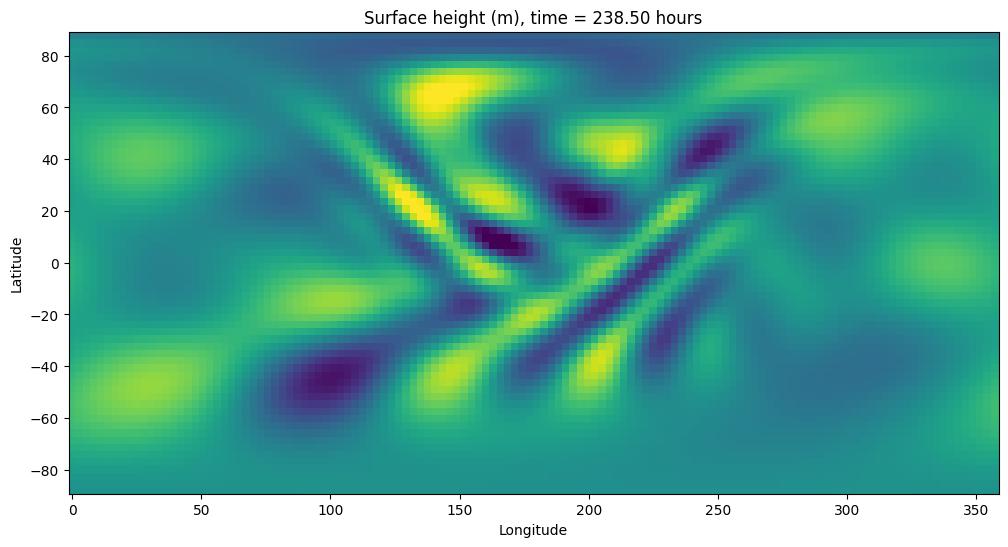

In [42]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(np.pi/2 - theta)*360/2/np.pi, np.squeeze(phi)*360/2/np.pi)

# Define an animation function
def drawframe(n):
    plt.clf()
    height = plt.pcolor(Y, X, h_save[n,:,:], vmin=-0.1, vmax=0.1)
    # Specify the axis limits and labels
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### 3.3 Student investigation
<a id='section3pt3'></a>
Create a virtual tide gauge by sampling the height at a point at a latitude of 45ºN and longitude of 90ºW and plot the timeseries of the height at this point in the cells below. Notice that as the gravity waves propagate around the Earth, their shape changes. Discuss physical mechanisms that might cause the shape of the wave to change as the wave propagates.

ADD PLOTS AND DISCUSSION HERE

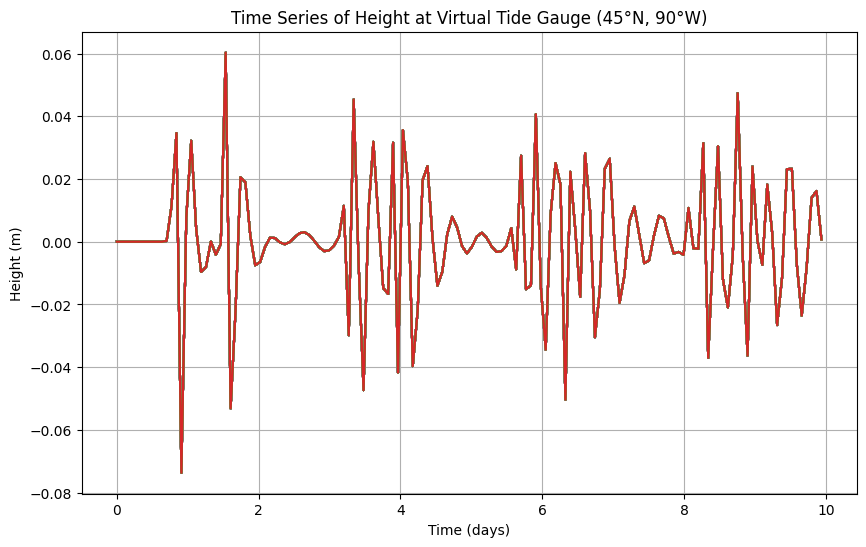

In [44]:
# Convert target latitude and longitude to radians
target_lat = np.deg2rad(45)
target_lon = np.deg2rad(90)

# Find the closest grid point to the target location
lat_diff = np.abs(lat - np.rad2deg(target_lat))
lon_diff = np.abs(phi - target_lon)

# Get the indices of the closest grid points
lat_idx = np.argmin(lat_diff, axis=0)
lon_idx = np.argmin(lon_diff, axis=0)

# Sample the height at the virtual tide gauge location for all saved timesteps
gauge_height = [h[lon_idx, lat_idx] for h in h_save]

# Convert time to days for plotting
time_days = np.array(t_save) / day

# Plot the time series
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(time_days, gauge_height, label='Virtual Tide Gauge')
plt.xlabel('Time (days)')
plt.ylabel('Height (m)')
plt.title('Time Series of Height at Virtual Tide Gauge (45°N, 90°W)')
plt.grid()
plt.show()


- As the gravity waves propagate globally, the virtual tide gauge records the passage of multiple wavefronts. This results in oscillations in the recorded height, corresponding to the crests and troughs of these waves.
- On a sphere, waves propagate in multiple directions and can interact with each other. This interaction leads to constructive and destructive interference, causing irregular oscillation patterns
- The Coriolis effect causes waves to be deflected, modifying their trajectories and arrival times at the tide gauge.
- Gravity waves are dispersive, meaning waves of different wavelengths travel at different speeds. As a result, the shape of the wave changes, and the oscillations at the gauge reflect this dispersion.
- Waves traveling on a sphere wrap around the Earth, leading to repeated arrivals at the same location. This creates periodic oscillations over time.

In the simulation above, the Tsunami wave travels around the planet many times. In reality, the waves will partially dissipate when they reach shorelines. In the spherical shallow water equation code above (or in a new code block below), add a forcing term to the shallow water equations that damps the waves for longitudes larger than $\pm 90^\circ$. Specifically, add a forcing function to the right hand side of the height equation of the following form:

$$ - (1/\tau) f(\phi) h$$

where

$$ f(\phi) = \frac{1}{2}\left(1+tanh\left(\frac{\phi-3\pi/2}{\pi/10}\right)\right) + \frac{1}{2}\left(1-tanh\left(\frac{\phi-\pi/2}{\pi/10}\right)\right) $$

and $\phi$ is the co-latitude in radians and $\tau$ is a damping timescale. A timescale of $\tau=0.1$ days should be sufficient to damp the waves.

With this damping term active, much more slowly propagating waves should be visible. These are shallow water Rossby waves. Estimate the east/west phase speed of these Rossby waves and compare them with the phase speed that you can infer from the simulation by plotting the height, $h$, as a function of longitude and time. Discuss the spatial structure of the Rossby waves and any discrepancies that you see between your estimated and measured phase speeds.

## 4. Optional further investigations

* In the example of the shallow water equations on a sphere, introduce bathymetry by making $H$ a function of latitude and longitude. Make sure that you modify the equations in Dedalus appropriately. How do the waves behave when they encounter shallow water (e.g. a localized seamount)?

* It is quite difficult to simulate changing sea level (sometimes called wetting and drying), which is why the examples above do not include land. However, we can estimate the distance that a Tsunami will propagate using physical and dimensional arguments. Consider, for example, a flat, sloping beach. In the absence of energy dissipation, estimate the distance that a wave will propagate onshore. How could you modify this estimate to include energy dissipation (or drag)?